In [1]:
import tensorflow as tf
import glob as gb
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,UpSampling2D,BatchNormalization
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
from tensorflow.keras import datasets,models,layers
import seaborn as sn
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import os,cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from keras.applications import InceptionV3
from keras.layers import Conv2D, MaxPool2D,Dropout, Dense, Input, concatenate,GlobalAveragePooling2D, AveragePooling2D,Flatten

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
path="../input/intel-image-classification/seg_train/"

In [3]:
os.listdir(path +'seg_train')

['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']

In [4]:
def getcode(n) : 
    for x , y in code.items() : 
        if n == y : 
            return x    

In [5]:
code = {'buildings':0 ,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}
X = []
y = []
for folder in  os.listdir(path +'seg_train') : 
    files = gb.glob(pathname= str( path +'seg_train//' + folder + '/*.jpg'))
    for file in files: 
        image = cv2.imread(file)
        image_array = cv2.resize(image , (96,96))
        X.append(list(image_array))
        y.append(code[folder])

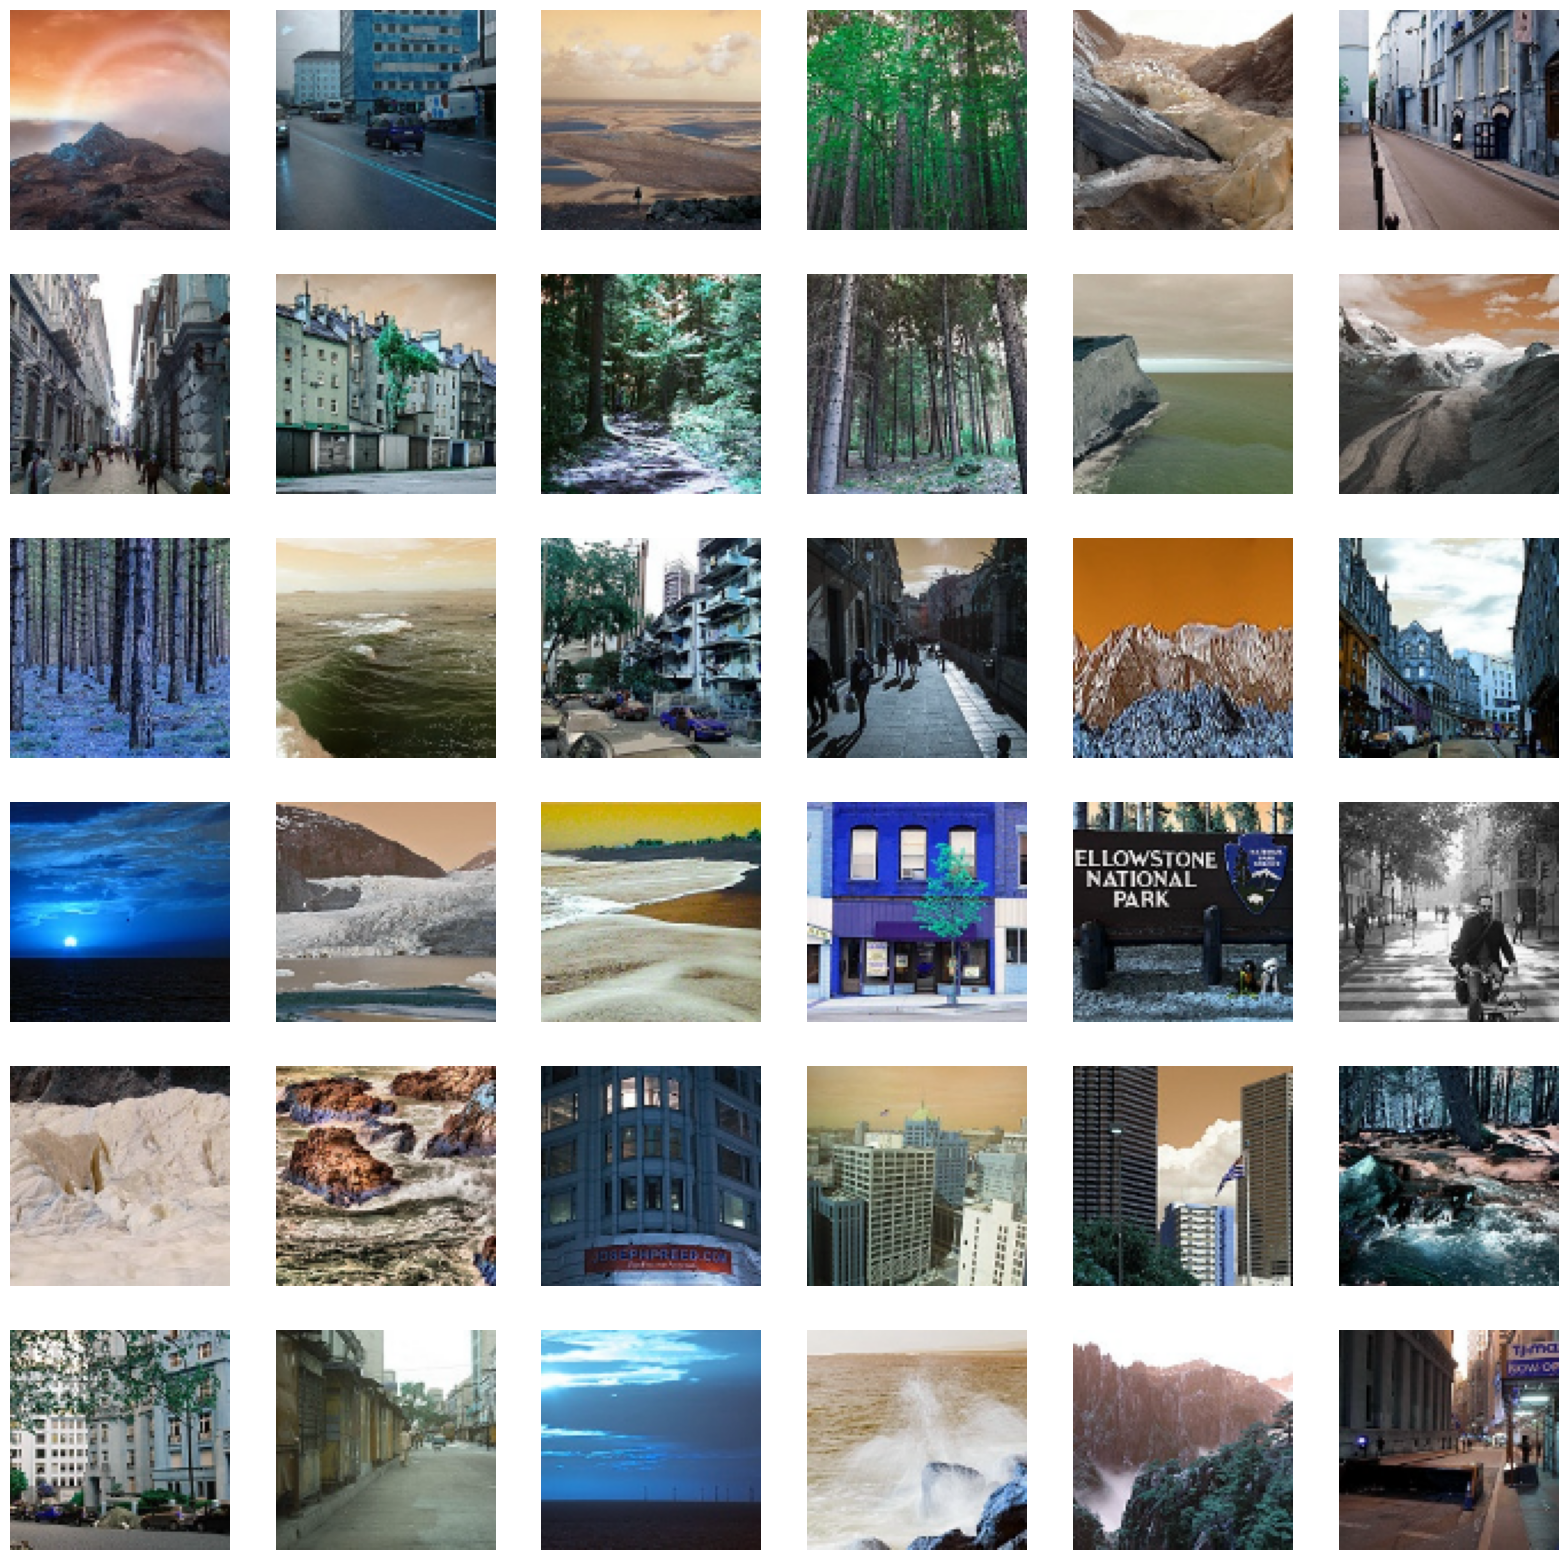

In [6]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X),36))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(X[i])   
    plt.axis('off')
#     plt.title(getcode(y[i]))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [8]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
print(f'X_train shape  is {X_train.shape}')
print(f'X_test shape  is {X_test.shape}')
print(f'y_train shape  is {y_train.shape}')
print(f'y_test shape  is {y_test.shape}')

X_train shape  is (11227, 96, 96, 3)
X_test shape  is (2807, 96, 96, 3)
y_train shape  is (11227,)
y_test shape  is (2807,)


In [9]:
num_classes = 10
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

In [10]:
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3,filters_5x5_reduce, filters_5x5, filters_pool, name=None):
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)
    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)
    pool = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool = Conv2D(filters_pool, (1, 1), padding='same', activation='relu')(pool)
    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool], axis=3, name=name)
    return output


In [11]:

input_layer = Input(shape=(96, 96, 3))
x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2')(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)
x = inception_module(x,filters_1x1=64,filters_3x3_reduce=96, filters_3x3=128,filters_5x5_reduce=16, filters_5x5=32,filters_pool=32, name='inception_3a')
x = inception_module(x,filters_1x1=128,filters_3x3_reduce=128, filters_3x3=192,filters_5x5_reduce=32, filters_5x5=96,filters_pool=64, name='inception_3b')
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)
x = inception_module(x,filters_1x1=192,filters_3x3_reduce=96, filters_3x3=208,filters_5x5_reduce=16,filters_5x5=48,filters_pool=64, name='inception_4a')
x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(10, activation='softmax', name='auxilliary_output_1')(x1)
x = inception_module(x,filters_1x1=160,filters_3x3_reduce=112, filters_3x3=224,filters_5x5_reduce=24,filters_5x5=64,filters_pool=64,name='inception_4b')
x = inception_module(x,filters_1x1=128,filters_3x3_reduce=128, filters_3x3=256,filters_5x5_reduce=24,filters_5x5=64, filters_pool=64,name='inception_4c')
x = inception_module(x,filters_1x1=112,filters_3x3_reduce=144, filters_3x3=288,filters_5x5_reduce=32,filters_5x5=64, filters_pool=64, name='inception_4d')
x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(10, activation='softmax', name='auxilliary_output_2')(x2)
x = inception_module(x,filters_1x1=256,filters_3x3_reduce=160, filters_3x3=320,filters_5x5_reduce=32,filters_5x5=128, filters_pool=128, name='inception_4e')
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)
x = inception_module(x,filters_1x1=256,filters_3x3_reduce=160, filters_3x3=320,filters_5x5_reduce=32,filters_5x5=128, filters_pool=128, name='inception_5a')
x = inception_module(x, filters_1x1=384,filters_3x3_reduce=192, filters_3x3=384,filters_5x5_reduce=48,filters_5x5=128, filters_pool=128, name='inception_5b')
x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)
x = Dropout(0.4)(x)
x = Dense(10, activation='softmax', name='output')(x)

model = Model(input_layer, [x, x1, x2], name='inception_v1')

In [12]:
model.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [13]:
model.summary()

Model: "inception_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv_1_7x7/2 (Conv2D)       (None, 48, 48, 64)           9472      ['input_1[0][0]']             
                                                                                                  
 max_pool_1_3x3/2 (MaxPooli  (None, 24, 24, 64)           0         ['conv_1_7x7/2[0][0]']        
 ng2D)                                                                                            
                                                                                                  
 conv_2a_3x3/1 (Conv2D)      (None, 24, 24, 64)           4160      ['max_pool_1_3x3/2[

In [14]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.1,           
    patience=5,           
    min_lr=1e-7,          
    verbose=1       
) 
result = model.fit(X_train, [y_train, y_train, y_train],validation_data=(X_test, [y_test, y_test, y_test]), epochs=10, batch_size=125,callbacks=[reduce_lr])

Epoch 1/10
90/90 [==============================] - 37s 127ms/step - loss: 5.5067 - output_loss: 1.8528 - auxilliary_output_1_loss: 1.8046 - auxilliary_output_2_loss: 1.8493 - output_accuracy: 0.1826 - auxilliary_output_1_accuracy: 0.2070 - auxilliary_output_2_accuracy: 0.1841 - val_loss: 4.8048 - val_output_loss: 1.7692 - val_auxilliary_output_1_loss: 1.4809 - val_auxilliary_output_2_loss: 1.5547 - val_output_accuracy: 0.1731 - val_auxilliary_output_1_accuracy: 0.3719 - val_auxilliary_output_2_accuracy: 0.3627 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - 7s 74ms/step - loss: 4.0064 - output_loss: 1.3534 - auxilliary_output_1_loss: 1.2980 - auxilliary_output_2_loss: 1.3550 - output_accuracy: 0.4266 - auxilliary_output_1_accuracy: 0.4422 - auxilliary_output_2_accuracy: 0.4129 - val_loss: 3.4473 - val_output_loss: 1.1961 - val_auxilliary_output_1_loss: 1.0922 - val_auxilliary_output_2_loss: 1.1591 - val_output_accuracy: 0.5069 - val_auxilliary_output_1_accuracy: 0.553

In [15]:
model.evaluate(X_test, y_test)

88/88 [==============================] - 3s 20ms/step - loss: 1.8109 - output_loss: 0.6148 - auxilliary_output_1_loss: 0.5934 - auxilliary_output_2_loss: 0.6027 - output_accuracy: 0.7820 - auxilliary_output_1_accuracy: 0.7855 - auxilliary_output_2_accuracy: 0.7816


[1.810888648033142,
 0.6147797107696533,
 0.5934180021286011,
 0.602691113948822,
 0.781973659992218,
 0.7855361700057983,
 0.7816174030303955]